In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
#reproducibility
np.random.seed(0)
torch.manual_seed(0)

In [5]:
#create dataset
# Noisy nonlinear regression dataset
X = np.linspace(0, 1, 200)
y = np.sin(2 * np.pi * X) + np.random.normal(0, 0.2, 200)

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val   = torch.FloatTensor(X_val)
y_val   = torch.FloatTensor(y_val)

In [7]:
#model class with optional dropout
class Net(nn.Module):
    def __init__(self, hidden=64, dropout_p=0.0):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
#training function
def train_model(model, optimizer, criterion, X_train, y_train, X_val, y_val, epochs=300):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # --- training ---
        model.train()
        y_pred = model(X_train)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # --- validation ---
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val)

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

    return train_losses, val_losses

In [11]:
#run experiments
criterion = nn.MSELoss()
epochs = 300

results = {}

# 1) Baseline
model = Net(hidden=64, dropout_p=0.0)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0)
results["Baseline"] = train_model(model, optimizer, criterion, X_train, y_train, X_val, y_val, epochs)

# 2) Weight Decay (L2)
model = Net(hidden=64, dropout_p=0.0)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
results["Weight Decay (1e-4)"] = train_model(model, optimizer, criterion, X_train, y_train, X_val, y_val, epochs)

# 3) Dropout
model = Net(hidden=64, dropout_p=0.3)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0)
results["Dropout (p=0.3)"] = train_model(model, optimizer, criterion, X_train, y_train, X_val, y_val, epochs)

# 4) Dropout + Weight Decay
model = Net(hidden=64, dropout_p=0.3)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
results["Dropout + Weight Decay"] = train_model(model, optimizer, criterion, X_train, y_train, X_val, y_val, epochs)

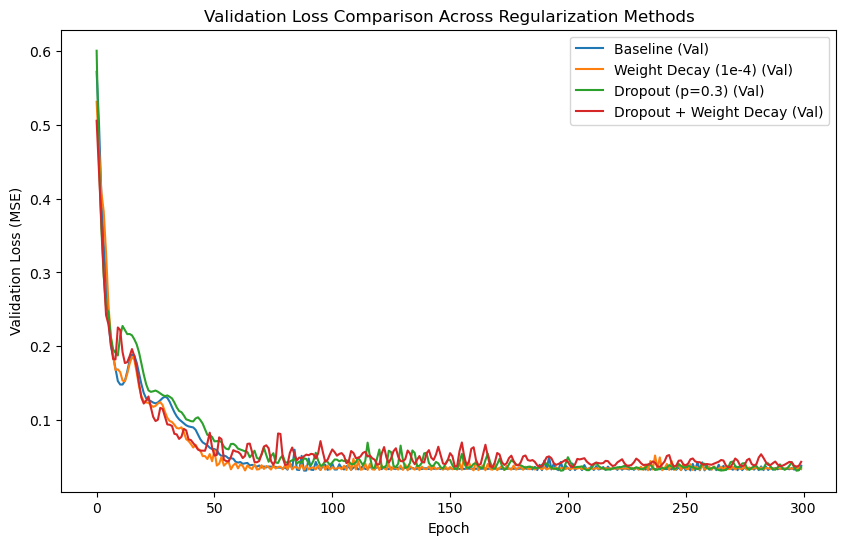

In [13]:
#plot all curves
plt.figure(figsize=(10,6))

for name, (train_losses, val_losses) in results.items():
    plt.plot(val_losses, label=f"{name} (Val)")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss (MSE)")
plt.title("Validation Loss Comparison Across Regularization Methods")
plt.legend()
plt.show()

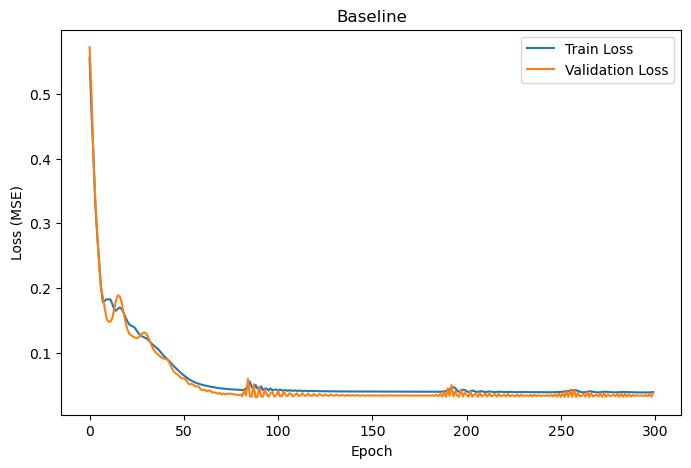

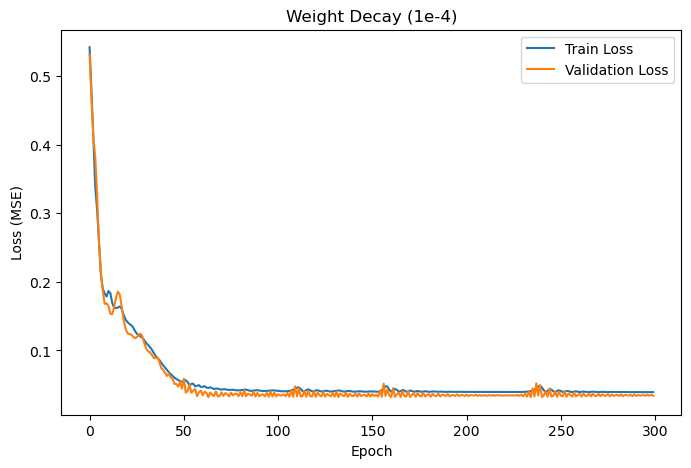

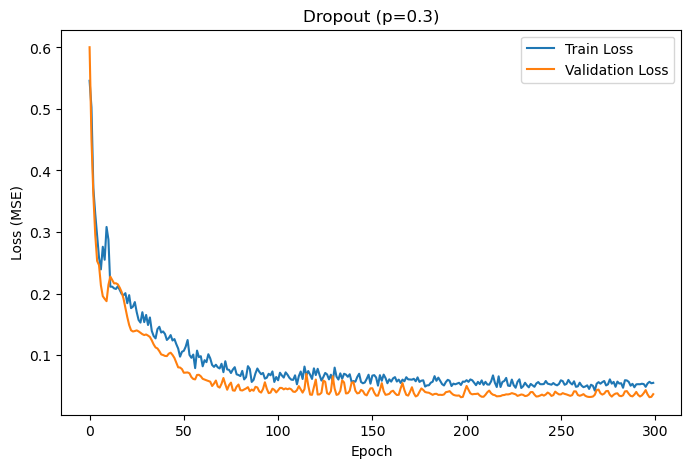

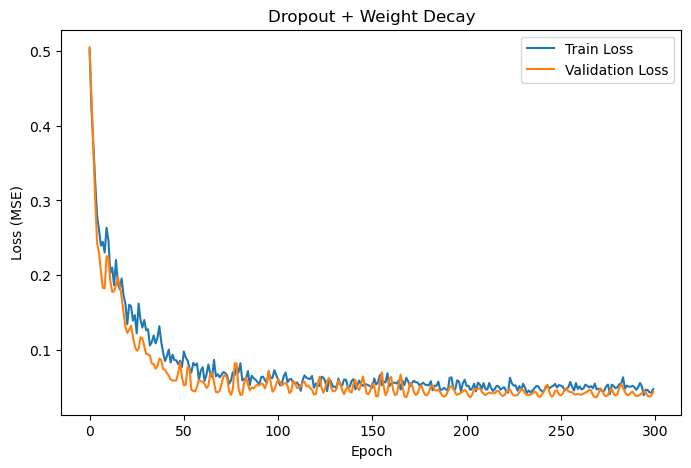

In [15]:
#plot training and validation curves for each setup
for name, (train_losses, val_losses) in results.items():
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title(name)
    plt.legend()
    plt.show()

## Objective
Compare how **regularization techniques** affect generalization in neural networks by tracking **training vs validation loss** under four setups:

1. Baseline (no regularization)
2. Weight decay (L2 regularization)
3. Dropout
4. Dropout + weight decay

---

## Key Idea
Regularization can slightly slow training (higher train loss) while improving **generalization** (lower validation loss).

 ## Results Summary
### What to Look For
- **Overfitting** shows up as a growing gap where training loss keeps decreasing but validation loss stops improving or rises.
- **Regularization** methods often:
  - slightly increase training loss,
  - but reduce validation loss volatility and improve generalization.

### Techniques Compared
- **Weight Decay (L2):** discourages large weights, leading to smoother models.
- **Dropout:** randomly disables neurons during training, preventing co-adaptation.
- **Dropout + Weight Decay:** often provides the most stable generalization behavior.
                                                                                                  